In [63]:
#Load in packages
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import contextily as cx
import warnings
import geoplot as gplt
import geoplot.crs as gcrs
from numpy import log10
import os
from shapely.geometry.point import Point
import matplotlib.cbook as cbook
from matplotlib.gridspec import GridSpec
import plotly.express as px

In [3]:
#Allow full display of columns in data
pd.set_option("display.max_columns", 100,"display.max_rows",100)

In [125]:
#Read in Durham Police Department call data
dpdcalls = gpd.read_file('/Users/sadiesheridan/Desktop/dpdshapefile/dpdshapefile.shp')
dpdcalls.set_crs('epsg:4326')
dpdcalls.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [126]:
#Determine which call types to keep with nature_list
nature_list = ('PANHANDLING OR NUISANCE', 'SUICIDE THREAT', 'INTOXICATED PERSON', 'MENTAL DISORDER', 'WELFARE CHECK', 'URGENT WELFARE CHECK', 'ASSIST PERSON', 'CRISIS', 'TRESPASS OR UNWANTED', 'DISTURBANCE')

#Determine which priority levels to use for priority_list
priority_list = ['2', '3', '4', '5', '6']

#Determine which beats are in Durham
policebeats_list_obj = ['121', '122', '112', '111', '123', '114', '113', '124', '212', '214', '213', '211', '223', '222', '221', '224', '313', '312', '321', '314', '323', '324', '322', '311', '411', '415', '412', '413', '414', '422', '421', '423', '511', '512', '513']

In [127]:
#Filter out cancelled calls and self initiated calls
dpdcalls = dpdcalls.loc[dpdcalls["Source"] != "Self Initiated"].copy()
dpdcalls = dpdcalls.loc[dpdcalls["Cancelled"] == 0].copy()
dpdcalls = dpdcalls.loc[(dpdcalls["Beat"] != "DSO") & (dpdcalls["Beat"] != "SSA")].copy()

#Filter out for hang ups and unreadable natures (in the case that the call types in nature_list aren't specified)
# dpdcalls = dpdcalls.loc[dpdcalls["Nature"] != "HANG UP"].copy()
# dpdcalls = dpdcalls.loc[(dpdcalls["Nature"] != "HANG UP WIRELESS PHASE 1") & (dpdcalls["Nature"] != "0") & (dpdcalls["Nature"] != "16") & (dpdcalls["Nature"] != "DIRECTED PATROL") & (dpdcalls["Nature"] != "NO apt # or phone") & (dpdcalls["Nature"] != "\\") & (dpdcalls["Nature"] != "VIN: JHMFA36226S011840 not sto") & (dpdcalls["Nature"] != "DISy") & (dpdcalls["Nature"] != "VEr") & (dpdcalls["Nature"] != "DIST") & (dpdcalls['Nature'] != 'HANG UP WIRELESS PHASE 2')].copy()

#Filter out for only calls in nature_list
dpdcalls = dpdcalls[dpdcalls['Nature'].isin(nature_list)].copy()

#Filter out for only priority levels in priority_list
dpdcalls = dpdcalls[dpdcalls['Priority'].isin(priority_list)].copy()

#Filter out for only calls within Durham Police Beats
dpdcalls = dpdcalls.loc[dpdcalls['Beat'].isin(policebeats_list_obj)].copy()

#Filter out null x and y values
dpdcalls = dpdcalls.loc[(dpdcalls["X"] != 0) & (dpdcalls["Y"] != 0)].copy()

dpdcalls.head()

,Event Numb,Case Numbe,Call Date,Call Time,Source,Priority,Nature,Address,X,Y,District,Beat,Dispositio,Cancelled,geometry
72,21000110,None,1/1/2021,12:40:00AM,Phone Call,2,DISTURBANCE,3600 N ROXBORO ST,2029653,832422,D2,213,Resolved Without Report,0,POINT (-78.89970 36.03711)
74,21000113,None,1/1/2021,12:41:03AM,Wireless 911 Call,2,TRESPASS OR UNWANTED,2300 GUESS RD,2022916,828272,D2,211,Resolved Without Report,0,POINT (-78.92250 36.02572)
75,21000114,None,1/1/2021,12:41:53AM,Wireless 911 Call,3,CRISIS,0 HAYTI LN,2030397,813534,D4,411,Resolved Without Report,0,POINT (-78.89725 35.98522)
78,21000119,None,1/1/2021,12:44:24AM,E-911,3,WELFARE CHECK,500 E MAIN ST,2031074,816191,D5,513,Resolved Without Report,0,POINT (-78.89496 35.99252)
84,21000130,None,1/1/2021,12:49:53AM,Wireless 911 Call,2,DISTURBANCE,5100 OLD CHAPEL HILL RD,2003518,799213,D3,323,Resolved Without Report,0,POINT (-78.98811 35.94592)


In [128]:
#Create lists for specific beat groups
group1_list = [112, 113, 214, 223, 411, 511, 512, 513]
group2_list = [122, 222, 111, 213]
commsafe_list = [112, 113, 214, 223, 411, 511, 512, 513, 122, 222, 111, 213]

In [129]:
#Create the same lists to use when Beat is in object form
group1_list_obj = ['112', '113', '214', '223', '411', '511', '512', '513']
group2_list_obj = ['122', '222', '111', '213']
commsafe_list_obj = ['112', '113', '214', '223', '411', '511', '512', '513', '122', '222', '111', '213']

In [130]:
#Find most common Nature of calls
csdnature = dpdcalls.groupby(['Nature']).size().to_frame(name = 'Durham Beats Call Count').reset_index()
csdnature.sort_values(by='Durham Beats Call Count', inplace=True, ascending=False)
csdnature.head(20)

,Nature,Durham Beats Call Count
2,DISTURBANCE,7919
7,TRESPASS OR UNWANTED,4940
0,ASSIST PERSON,3053
8,URGENT WELFARE CHECK,1950
9,WELFARE CHECK,1651
1,CRISIS,1323
5,PANHANDLING OR NUISANCE,787
6,SUICIDE THREAT,582
3,INTOXICATED PERSON,440
4,MENTAL DISORDER,19


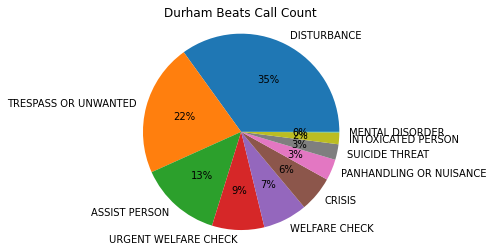

In [163]:
#Create a pie chart for the nature of calls
plt.pie(csdnature['Durham Beats Call Count'],autopct='%1.0f%%', labels=csdnature['Nature'])
plt.axis('equal')
plt.title('Durham Beats Call Count')
plt.show()

In [131]:
#Find the most common Nature of comsafe call types for just comsafe beats
csdnature_commsafe = dpdcalls.loc[dpdcalls['Beat'].isin(commsafe_list_obj)].copy()
csdnature_commsafe = csdnature_commsafe.groupby(['Nature']).size().to_frame(name = 'Community Safety Beats Call Count').reset_index()
csdnature_commsafe.sort_values(by='Community Safety Beats Call Count', inplace=True, ascending=False)
csdnature_commsafe

,Nature,Community Safety Beats Call Count
2,DISTURBANCE,3049
7,TRESPASS OR UNWANTED,2210
0,ASSIST PERSON,975
8,URGENT WELFARE CHECK,615
1,CRISIS,545
9,WELFARE CHECK,520
5,PANHANDLING OR NUISANCE,371
6,SUICIDE THREAT,199
3,INTOXICATED PERSON,188
4,MENTAL DISORDER,11


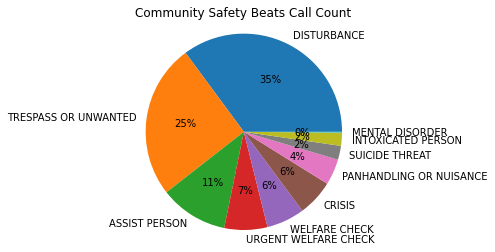

In [165]:
#Create a pie chart for the nature of calls for community safety beats
plt.pie(csdnature_commsafe['Community Safety Beats Call Count'], autopct='%1.0f%%', labels=csdnature['Nature'])
plt.axis('equal')
plt.title('Community Safety Beats Call Count')
plt.show()

In [166]:
#Find the most common Nature of comsafe call types for group 1 beats
csdnature_group1 = dpdcalls.loc[dpdcalls['Beat'].isin(group1_list_obj)].copy()
csdnature_group1 = csdnature_group1.groupby(['Nature']).size().to_frame(name = 'Group 1 Beats Call Count').reset_index()
csdnature_group1.sort_values(by='Group 1 Beats Call Count', inplace=True, ascending=False)
csdnature_group1

,Nature,Group 1 Beats Call Count
2,DISTURBANCE,1978
7,TRESPASS OR UNWANTED,1605
0,ASSIST PERSON,643
8,URGENT WELFARE CHECK,400
1,CRISIS,392
9,WELFARE CHECK,341
5,PANHANDLING OR NUISANCE,269
6,SUICIDE THREAT,153
3,INTOXICATED PERSON,142
4,MENTAL DISORDER,8


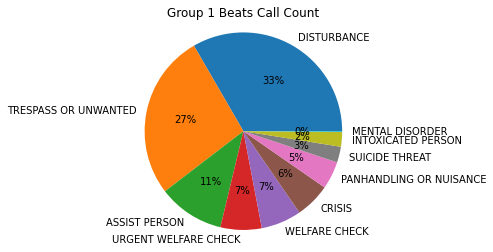

In [167]:
#Create a pie chart for the nature of calls for group 1 beats
plt.pie(csdnature_group1['Group 1 Beats Call Count'], autopct='%1.0f%%', labels=csdnature['Nature'])
plt.axis('equal')
plt.title('Group 1 Beats Call Count')
plt.show()

In [168]:
#Find the most common Nature of comsafe call types for group 2 beats
csdnature_group2 = dpdcalls.loc[dpdcalls['Beat'].isin(group2_list_obj)].copy()
csdnature_group2 = csdnature_group2.groupby(['Nature']).size().to_frame(name = 'Group 2 Beats Call Count').reset_index()
csdnature_group2.sort_values(by='Group 2 Beats Call Count', inplace=True, ascending=False)
csdnature_group2

,Nature,Group 2 Beats Call Count
2,DISTURBANCE,1071
7,TRESPASS OR UNWANTED,605
0,ASSIST PERSON,332
8,URGENT WELFARE CHECK,215
9,WELFARE CHECK,179
1,CRISIS,153
5,PANHANDLING OR NUISANCE,102
3,INTOXICATED PERSON,46
6,SUICIDE THREAT,46
4,MENTAL DISORDER,3


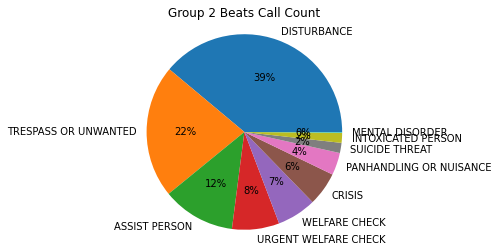

In [170]:
#Create a pie chart for the nature of calls for group 2 beats
plt.pie(csdnature_group2['Group 2 Beats Call Count'], autopct='%1.0f%%', labels=csdnature['Nature'])
plt.axis('equal')
plt.title('Group 2 Beats Call Count')
plt.show()

In [132]:
#Merge the csd nature tables together
csdnature_counts = pd.merge(csdnature_commsafe, csdnature, on='Nature')
csdnature_counts = csdnature_counts.set_index('Nature')
csdnature_counts

,Community Safety Beats Call Count,Durham Beats Call Count
Nature,,
DISTURBANCE,3049,7919
TRESPASS OR UNWANTED,2210,4940
ASSIST PERSON,975,3053
URGENT WELFARE CHECK,615,1950
CRISIS,545,1323
WELFARE CHECK,520,1651
PANHANDLING OR NUISANCE,371,787
SUICIDE THREAT,199,582
INTOXICATED PERSON,188,440


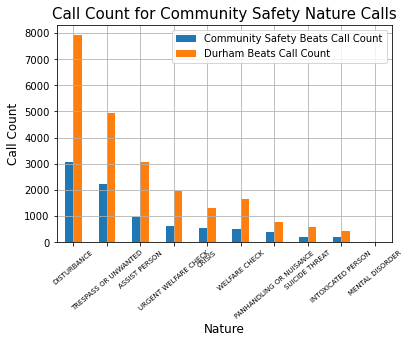

In [133]:
#Create a bar plot to compare nature count in durham and community safety beats
ax = csdnature_counts.plot.bar(grid=True)

plt.xticks(rotation=40, fontsize=7)
plt.title("Call Count for Community Safety Nature Calls", fontsize = 15)
plt.xlabel("Nature", fontsize=12)
plt.ylabel("Call Count", fontsize=12)
plt.show()

In [134]:
#Find the most common Nature of comsafe call types for just group 1 beats
csdnature_group1 = dpdcalls.loc[dpdcalls['Beat'].isin(group1_list_obj)].copy()
csdnature_group1 = csdnature_group1.groupby(['Nature']).size().to_frame(name = 'Group 1 Beats Call Count').reset_index()
csdnature_group1.sort_values(by='Group 1 Beats Call Count', inplace=True, ascending=False)
csdnature_group1

,Nature,Group 1 Beats Call Count
2,DISTURBANCE,1978
7,TRESPASS OR UNWANTED,1605
0,ASSIST PERSON,643
8,URGENT WELFARE CHECK,400
1,CRISIS,392
9,WELFARE CHECK,341
5,PANHANDLING OR NUISANCE,269
6,SUICIDE THREAT,153
3,INTOXICATED PERSON,142
4,MENTAL DISORDER,8


In [135]:
#Find the most common Nature of comsafe call types for just group 2 beats
csdnature_group2 = dpdcalls.loc[dpdcalls['Beat'].isin(group2_list_obj)].copy()
csdnature_group2 = csdnature_group2.groupby(['Nature']).size().to_frame(name = 'Group 2 Beats Call Count').reset_index()
csdnature_group2.sort_values(by='Group 2 Beats Call Count', inplace=True, ascending=False)
csdnature_group2

,Nature,Group 2 Beats Call Count
2,DISTURBANCE,1071
7,TRESPASS OR UNWANTED,605
0,ASSIST PERSON,332
8,URGENT WELFARE CHECK,215
9,WELFARE CHECK,179
1,CRISIS,153
5,PANHANDLING OR NUISANCE,102
3,INTOXICATED PERSON,46
6,SUICIDE THREAT,46
4,MENTAL DISORDER,3


In [136]:
#Merge the csd groups together
csdnature_counts_groups = pd.merge(csdnature_group1, csdnature_group2, on='Nature')
csdnature_counts_groups = csdnature_counts_groups.set_index('Nature')
csdnature_counts_groups

,Group 1 Beats Call Count,Group 2 Beats Call Count
Nature,,
DISTURBANCE,1978,1071
TRESPASS OR UNWANTED,1605,605
ASSIST PERSON,643,332
URGENT WELFARE CHECK,400,215
CRISIS,392,153
WELFARE CHECK,341,179
PANHANDLING OR NUISANCE,269,102
SUICIDE THREAT,153,46
INTOXICATED PERSON,142,46


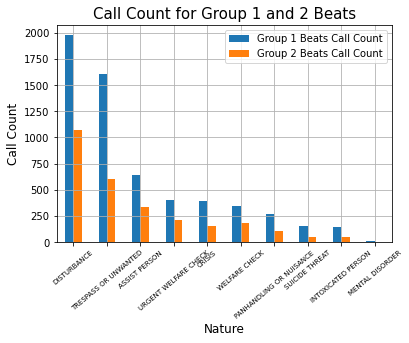

In [137]:
#Create a bar plot to compare nature count in group 1 and 2
ax = csdnature_counts_groups.plot.bar(grid=True)

plt.xticks(rotation=40, fontsize=7)
plt.title("Call Count for Group 1 and 2 Beats", fontsize = 15)
plt.xlabel("Nature", fontsize=12)
plt.ylabel("Call Count", fontsize=12)
plt.show()

In [138]:
#Find the most common Address of calls
calladdress = dpdcalls.groupby(['Address']).size().to_frame(name = 'Address Count').reset_index()
calladdress.sort_values(by='Address Count', inplace=True, ascending=False)
calladdress.head(10)

,Address,Address Count
2333,3400 HILLSBOROUGH RD,341
536,1000 N MIAMI BLVD,238
1593,2100 N ROXBORO ST,199
3021,5000 NC 55 HWY,169
748,1200 E MAIN ST,165
3537,800 W CLUB BLVD,149
1587,2100 HOLLOWAY ST,138
1794,2500 GUESS RD,134
1903,2700 GUESS RD,134
2154,300 S LASALLE ST,131


In [139]:
#Find the most common address of calls for community safety beats
callsaddress_commsafe = dpdcalls.loc[dpdcalls['Beat'].isin(commsafe_list_obj)].copy()
callsaddress_commsafe = callsaddress_commsafe.groupby(['Address']).size().to_frame(name = 'Address Count').reset_index()
callsaddress_commsafe['Address Count'] = callsaddress_commsafe['Address Count'].astype(str).astype(int)
callsaddress_commsafe.sort_values(by='Address Count', inplace=True, ascending=False)
callsaddress_commsafe.head(10)

,Address,Address Count
141,1000 N MIAMI BLVD,238
496,2100 N ROXBORO ST,199
214,1200 E MAIN ST,165
493,2100 HOLLOWAY ST,138
478,2000 N ROXBORO ST,129
695,3600 N ROXBORO ST,121
1050,900 CHALK LEVEL RD,98
741,400 LIBERTY ST,97
821,4800 DANUBE LN,94
136,1000 N ALSTON AVE,94


In [140]:
#Read in policebeats data set
policebeats = gpd.read_file('/Users/sadiesheridan/Desktop/Police_Beats/Police_Beats.shp')
policebeats.set_crs('epsg:4326')
policebeats.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [141]:
#Filter out beats not in Durham for policebeats
policebeats_list = [121, 122, 112, 111, 123, 114, 113, 124, 212, 214, 213, 211, 223, 222, 221, 224, 313, 312, 321, 314, 323, 324, 322, 311, 411, 415, 412, 413, 414, 422, 421, 423, 511, 512, 513]
policebeats = policebeats.loc[policebeats["LAWBEAT"].isin(policebeats_list)].copy()
policebeats.head()

,OBJECTID,PERIMETER,STATUS,CONTIGUOUS,LAWDIST,LAWBEAT,CAD,GIS_DataA1,ShapeSTAre,ShapeSTLen,geometry
11,12,94210.453125,I,no,D2,224,224,None,7.014559e+07,94210.453140,"POLYGON ((-78.86340 36.13179, -78.86340 36.131..."
12,13,116621.601562,I,yes,D2,224,224,None,1.449941e+08,116621.571622,"POLYGON ((-78.91393 36.09660, -78.91391 36.096..."
13,14,12884.019531,I,no,D2,224,224,None,4.966974e+06,12884.022638,"POLYGON ((-78.87366 36.09793, -78.87363 36.097..."
14,15,16886.179688,I,no,D2,224,224,None,6.526409e+06,16886.182870,"POLYGON ((-78.88585 36.08830, -78.88585 36.088..."
15,16,50498.308594,I,yes,D2,222,222,None,1.066247e+08,50498.309761,"POLYGON ((-78.91508 36.07716, -78.91321 36.077..."


In [142]:
#Dissolving duplicate beats
policebeats = policebeats.to_crs("4326")
policebeats = policebeats.dissolve(by="LAWBEAT")
policebeats["LBeat"] = policebeats.index
policebeats = policebeats.reset_index()
policebeats["id"] = policebeats.index
policebeats.head()

,LAWBEAT,geometry,OBJECTID,PERIMETER,STATUS,CONTIGUOUS,LAWDIST,CAD,GIS_DataA1,ShapeSTAre,ShapeSTLen,LBeat,id
0,111,"POLYGON ((-78.89039 36.01517, -78.89038 36.015...",50,28608.800781,I,yes,D1,111,None,2.010252e+07,28608.799743,111,0
1,112,"POLYGON ((-78.88787 36.01473, -78.88734 36.014...",51,26265.849609,I,yes,D1,112,None,2.079934e+07,26265.852604,112,1
2,113,"POLYGON ((-78.87372 35.99369, -78.87458 35.991...",62,20667.539062,I,yes,D1,113,None,2.159195e+07,20667.538873,113,2
3,114,"MULTIPOLYGON (((-78.84053 35.95436, -78.84021 ...",65,53321.980469,I,yes,D1,114,None,6.103382e+07,53321.974873,114,3
4,121,"MULTIPOLYGON (((-78.80746 35.99706, -78.80746 ...",38,14495.120117,I,no,D1,121,None,7.008533e+06,14495.120026,121,4


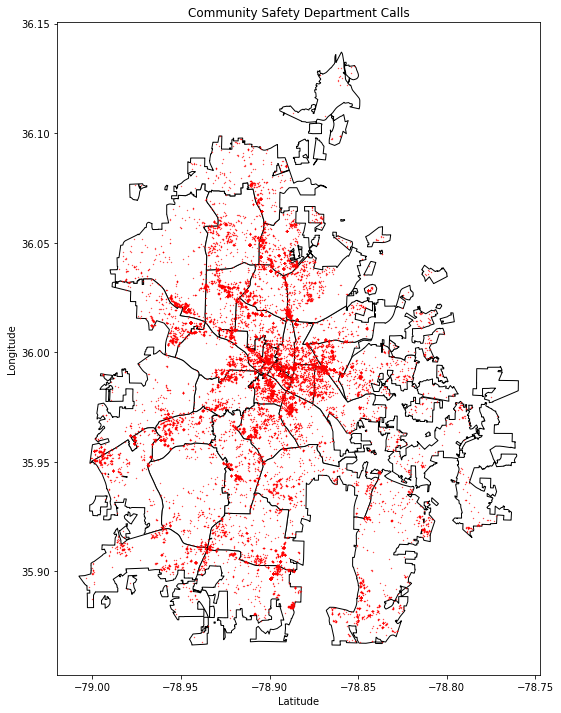

In [143]:
#Plot the two data sets together setting the aspect 'equal'
fig, ax = plt.subplots(figsize=(12, 12))

policebeats.plot(ax=ax, color='white', edgecolor='black')

dpdcalls.plot(ax=ax, marker='o', color='red', markersize=0.1)

ax.set(title='Community Safety Department Calls')
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

In [144]:
#Filter calls and police beats for just community safety beats
commsafe_beats = policebeats.loc[policebeats['LAWBEAT'].isin(commsafe_list)].copy()

commsafe_calls = dpdcalls.loc[dpdcalls['Beat'].isin(commsafe_list_obj)].copy()

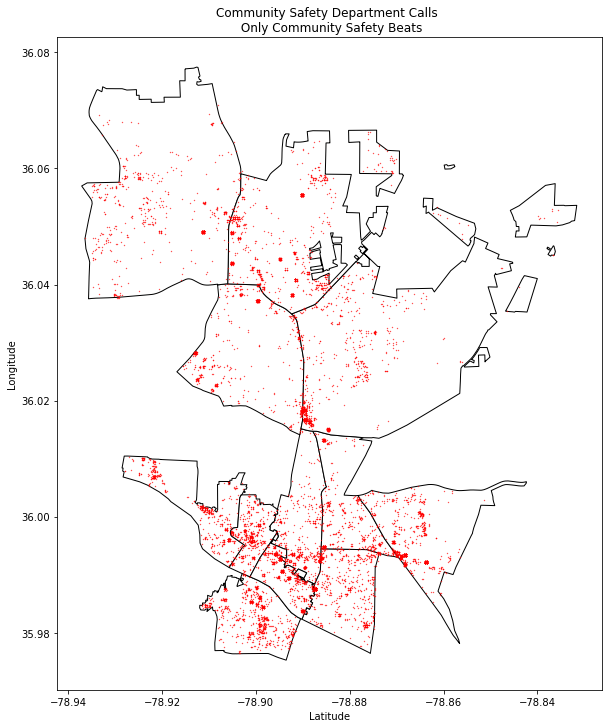

In [145]:
#Plot the two data sets together setting the aspect 'equal'
fig, ax = plt.subplots(figsize=(12, 12))

commsafe_beats.plot(ax=ax, color='white', edgecolor='black')

commsafe_calls.plot(ax=ax, marker='o', color='red', markersize=0.1)

ax.set(title='Community Safety Department Calls \n Only Community Safety Beats')
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

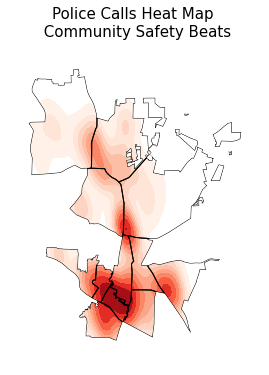

In [157]:
#Heat map of calls
ax = gplt.kdeplot(
    commsafe_calls, clip=commsafe_beats.geometry,
    shade=True, cmap='Reds',
    projection=gplt.crs.AlbersEqualArea())
gplt.polyplot(commsafe_beats, ax=ax, zorder=1, edgecolor='Black')

plt.title("Police Calls Heat Map \n Community Safety Beats", fontsize = 15)
plt.show()

In [146]:
#Merge policebats data with call data using polygon geometry
policebeats_w_dpd = gpd.sjoin(policebeats, dpdcalls)
policebeats_w_dpd.info

<bound method DataFrame.info of     LAWBEAT                                           geometry  OBJECTID  \
0       111  POLYGON ((-78.89039 36.01517, -78.89038 36.015...        50   
0       111  POLYGON ((-78.89039 36.01517, -78.89038 36.015...        50   
0       111  POLYGON ((-78.89039 36.01517, -78.89038 36.015...        50   
0       111  POLYGON ((-78.89039 36.01517, -78.89038 36.015...        50   
0       111  POLYGON ((-78.89039 36.01517, -78.89038 36.015...        50   
..      ...                                                ...       ...   
34      513  POLYGON ((-78.89561 35.99710, -78.89553 35.997...        61   
34      513  POLYGON ((-78.89561 35.99710, -78.89553 35.997...        61   
34      513  POLYGON ((-78.89561 35.99710, -78.89553 35.997...        61   
34      513  POLYGON ((-78.89561 35.99710, -78.89553 35.997...        61   
34      513  POLYGON ((-78.89561 35.99710, -78.89553 35.997...        61   

       PERIMETER STATUS CONTIGUOUS LAWDIST  CAD GIS_Dat

In [147]:
#Grouping dpdcalls by beat
allcalls = policebeats_w_dpd.groupby(['LAWBEAT']).size().to_frame(name = 'calls_count').reset_index()
allcalls.head()

,LAWBEAT,calls_count
0,111,583
1,112,567
2,113,742
3,114,601
4,121,445


In [150]:
#Merge policebeats data with allcalls
callcount_beat = pd.merge(policebeats, allcalls, on ='LAWBEAT')
callcount_beat.head(3)

,LAWBEAT,geometry,OBJECTID,PERIMETER,STATUS,CONTIGUOUS,LAWDIST,CAD,GIS_DataA1,ShapeSTAre,ShapeSTLen,LBeat,id,calls_count
0,111,"POLYGON ((-78.89039 36.01517, -78.89038 36.015...",50,28608.800781,I,yes,D1,111,None,2.010252e+07,28608.799743,111,0,583
1,112,"POLYGON ((-78.88787 36.01473, -78.88734 36.014...",51,26265.849609,I,yes,D1,112,None,2.079934e+07,26265.852604,112,1,567
2,113,"POLYGON ((-78.87372 35.99369, -78.87458 35.991...",62,20667.539062,I,yes,D1,113,None,2.159195e+07,20667.538873,113,2,742


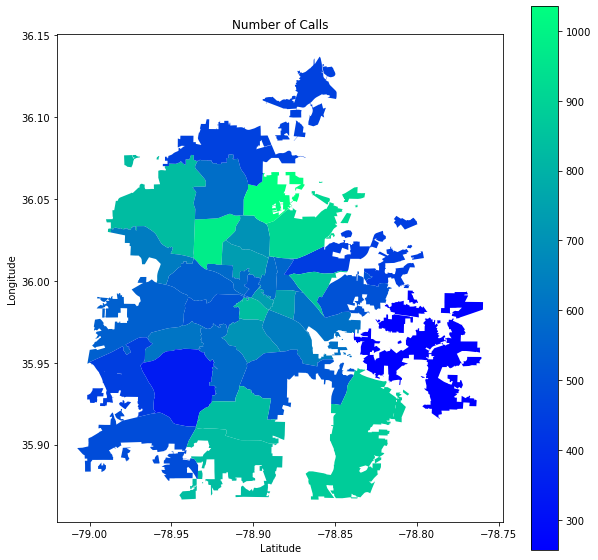

In [155]:
#Plot choropleth map of number of priority 2-6 calls with merged data
fig, ax = plt.subplots(figsize = (10,10))

callcount_beat.plot(column='calls_count',  
                         legend=True,  
                         cmap="winter", ax=ax, aspect=1);

ax.set(title='Number of Calls')
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

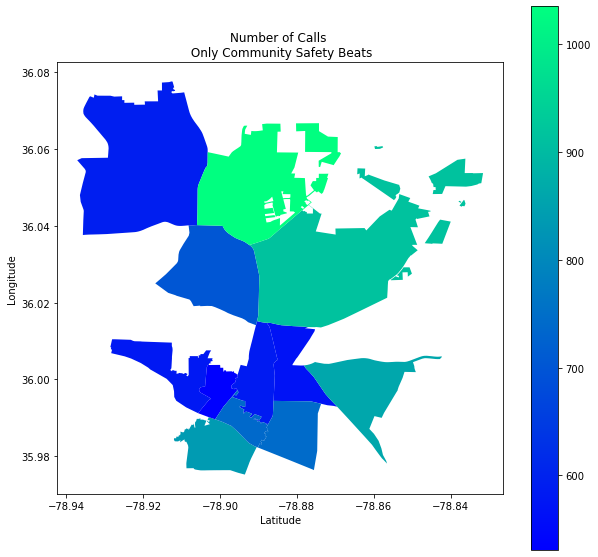

In [156]:
#Filter for just community safety beats
callcount_beat_commsafe = callcount_beat.loc[callcount_beat['LAWBEAT'].isin(commsafe_list)]

#Plot choropleth map of number of priority 2-6 calls with merged data
fig, ax = plt.subplots(figsize = (10,10))

callcount_beat_commsafe.plot(column='calls_count',  
                         legend=True,  
                         cmap="winter", ax=ax, aspect=1);

ax.set(title='Number of Calls \n Only Community Safety Beats')
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

In [177]:
#Read in census data for North Carolina 2020 census blocks
ncblockmap = gpd.read_file('/Users/sadiesheridan/Desktop/tl_2021_37_tabblock20/tl_2021_37_tabblock20.shp')

#Set the crs for the census data
ncblockmap = ncblockmap.to_crs("EPSG:4326")

#Filter the block map to only include Durham blocks (63)
durhamblockmap = ncblockmap[ncblockmap["COUNTYFP20"]=="063"]

In [178]:
#Load in 2020 race data from census bureau
racedata = pd.read_csv('/Users/sadiesheridan/Downloads/Race data/DECENNIALPL2020.P1_data_with_overlays_2022-06-06T132656.csv', skiprows = 1)

#Change id variable to GEOID20
racedata['GEOID20'] = racedata['id'].str[-15:]
racedata.drop('id', axis=1, inplace=True)

In [181]:
#Make index GEOID20 to join durhamblockmap and the racedata
durhamracemap = durhamblockmap.set_index('GEOID20').join(racedata.set_index('GEOID20'))

#Change the column names for durhamracemap
durhamracemap.columns = durhamracemap.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
durhamracemap.columns = durhamracemap.columns.str.replace('[#,@,&,!]', '')
durhamracemap.columns = durhamracemap.columns.str.replace('[:]', '_')
durhamracemap.head()

#Find the proportion of specific races compared to the total population
durhamracemap['propwhite']= durhamracemap['total_population_of_one_race_white_alone'] / durhamracemap['total_']
durhamracemap['propblack']= durhamracemap['total_population_of_one_race_black_or_african_american_alone'] / durhamracemap['total_']

warnings.filterwarnings('ignore')
durhamracemap.head(3)

,statefp20,countyfp20,tractce20,blockce20,name20,mtfcc20,ur20,uace20,uatype20,funcstat20,aland20,awater20,intptlat20,intptlon20,geometry,geographic_area_name,total_,total_population_of_one_race_,total_population_of_one_race_white_alone,total_population_of_one_race_black_or_african_american_alone,total_population_of_one_race_american_indian_and_alaska_native_alone,total_population_of_one_race_asian_alone,total_population_of_one_race_native_hawaiian_and_other_pacific_islander_alone,total_population_of_one_race_some_other_race_alone,total_population_of_two_or_more_races_,total_population_of_two_or_more_races_population_of_two_races_,total_population_of_two_or_more_races_population_of_two_races_white;_black_or_african_american,total_population_of_two_or_more_races_population_of_two_races_white;_american_indian_and_alaska_native,total_population_of_two_or_more_races_population_of_two_races_white;_asian,total_population_of_two_or_more_races_population_of_two_races_white;_native_hawaiian_and_other_pacific_islander,total_population_of_two_or_more_races_population_of_two_races_white;_some_other_race,total_population_of_two_or_more_races_population_of_two_races_black_or_african_american;_american_indian_and_alaska_native,total_population_of_two_or_more_races_population_of_two_races_black_or_african_american;_asian,total_population_of_two_or_more_races_population_of_two_races_black_or_african_american;_native_hawaiian_and_other_pacific_islander,total_population_of_two_or_more_races_population_of_two_races_black_or_african_american;_some_other_race,total_population_of_two_or_more_races_population_of_two_races_american_indian_and_alaska_native;_asian,total_population_of_two_or_more_races_population_of_two_races_american_indian_and_alaska_native;_native_hawaiian_and_other_pacific_islander,total_population_of_two_or_more_races_population_of_two_races_american_indian_and_alaska_native;_some_other_race,total_population_of_two_or_more_races_population_of_two_races_asian;_native_hawaiian_and_other_pacific_islander,total_population_of_two_or_more_races_population_of_two_races_asian;_some_other_race,total_population_of_two_or_more_races_population_of_two_races_native_hawaiian_and_other_pacific_islander;_some_other_race,total_population_of_two_or_more_races_population_of_three_races_,total_population_of_two_or_more_races_population_of_three_races_white;_black_or_african_american;_american_indian_and_alaska_native,total_population_of_two_or_more_races_population_of_three_races_white;_black_or_african_american;_asian,total_population_of_two_or_more_races_population_of_three_races_white;_black_or_african_american;_native_hawaiian_and_other_pacific_islander,total_population_of_two_or_more_races_population_of_three_races_white;_black_or_african_american;_some_other_race,total_population_of_two_or_more_races_population_of_three_races_white;_american_indian_and_alaska_native;_asian,total_population_of_two_or_more_races_population_of_three_races_white;_american_indian_and_alaska_native;_native_hawaiian_and_other_pacific_islander,total_population_of_two_or_more_races_population_of_three_races_white;_american_indian_and_alaska_native;_some_other_race,total_population_of_two_or_more_races_population_of_three_races_white;_asian;_native_hawaiian_and_other_pacific_islander,total_population_of_two_or_more_races_population_of_three_races_white;_asian;_some_other_race,total_population_of_two_or_more_races_population_of_three_races_white;_native_hawaiian_and_other_pacific_islander;_some_other_race,total_population_of_two_or_more_races_population_of_three_races_black_or_african_american;_american_indian_and_alaska_native;_asian,total_population_of_two_or_more_races_population_of_three_races_black_or_african_american;_american_indian_and_alaska_native;_native_hawaiian_and_other_pacific_islander,total_population_of_two_or_more_races_population_of_three_races_black_or_african_american;_american_indian_and_alaska_native;_some_other_race,total_population_of_two_or_more_ra

In [182]:
#Assign each census block to a police beat with for loop
cblockIndexToBeat = {}
sIndex = policebeats.sindex

for cblock_ind in durhamblockmap.index:
    cblock_geom = durhamblockmap.loc[cblock_ind]["geometry"]
    possibleBeatMatches = list(sIndex.intersection(cblock_geom.bounds))
    matched = False

    if len(possibleBeatMatches) > 0:
        possibleMatches = policebeats.iloc[possibleBeatMatches]
        intersectingAreas = possibleMatches.intersection(cblock_geom).area
        intersectingAreas /= cblock_geom.area
        police_beat_index = intersectingAreas.idxmax()
        maxIntersection = intersectingAreas.max()
    ##########
        if maxIntersection < 0.1:
            continue
    ##########
        if maxIntersection > 0:
            cblockIndexToBeat[cblock_ind] = policebeats.loc[police_beat_index]['LAWBEAT']
            matched = True

cblockDurhamBeats = ncblockmap[ncblockmap.index.isin(cblockIndexToBeat)]
cblockDurhamBeats['Beat'] = cblockDurhamBeats.index.map(lambda ii: cblockIndexToBeat[ii])

warnings.filterwarnings('ignore')

In [183]:
#Merging race data into the police beat and block data
raceineachbeat = pd.merge(racedata, cblockDurhamBeats)

#Grouping the population by police beat
raceineachbeat = raceineachbeat.groupby('Beat', as_index=False).sum()

#Adding beat geometry to popsumbybeat
raceineachbeat = pd.merge(policebeats, raceineachbeat, left_on='LAWBEAT', right_on='Beat')

#Change the column names for raceineachbeat
raceineachbeat.columns = raceineachbeat.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
raceineachbeat.columns = raceineachbeat.columns.str.replace('[#,@,&,!]', '')
raceineachbeat.columns = raceineachbeat.columns.str.replace('[:]', '_')
warnings.filterwarnings('ignore')

#Adding new columns to race in police beat data set
raceineachbeat['area'] = raceineachbeat.area
raceineachbeat['popdensity']= raceineachbeat['total_'] / raceineachbeat['area']
raceineachbeat['propwhite']= raceineachbeat['total_population_of_one_race_white_alone'] / raceineachbeat['total_']
raceineachbeat['propblack']= raceineachbeat['total_population_of_one_race_black_or_african_american_alone'] / raceineachbeat['total_']
raceineachbeat['propnativeamerican']= raceineachbeat['total_population_of_one_race_american_indian_and_alaska_native_alone'] / raceineachbeat['total_']
raceineachbeat['propasian']= raceineachbeat['total_population_of_one_race_asian_alone'] / raceineachbeat['total_']
raceineachbeat['proppacislander']= raceineachbeat['total_population_of_one_race_native_hawaiian_and_other_pacific_islander_alone'] / raceineachbeat['total_']
raceineachbeat['other']= raceineachbeat['total_'] - raceineachbeat['total_population_of_one_race_']
raceineachbeat['propother']= raceineachbeat['other'] / raceineachbeat['total_']
raceineachbeat.head()

,lawbeat,geometry,objectid,perimeter,status,contiguous,lawdist,cad,gis_dataa1,shapestare,shapestlen,lbeat,id,beat,total_,total_population_of_one_race_,total_population_of_one_race_white_alone,total_population_of_one_race_black_or_african_american_alone,total_population_of_one_race_american_indian_and_alaska_native_alone,total_population_of_one_race_asian_alone,total_population_of_one_race_native_hawaiian_and_other_pacific_islander_alone,total_population_of_one_race_some_other_race_alone,total_population_of_two_or_more_races_,total_population_of_two_or_more_races_population_of_two_races_,total_population_of_two_or_more_races_population_of_two_races_white;_black_or_african_american,total_population_of_two_or_more_races_population_of_two_races_white;_american_indian_and_alaska_native,total_population_of_two_or_more_races_population_of_two_races_white;_asian,total_population_of_two_or_more_races_population_of_two_races_white;_native_hawaiian_and_other_pacific_islander,total_population_of_two_or_more_races_population_of_two_races_white;_some_other_race,total_population_of_two_or_more_races_population_of_two_races_black_or_african_american;_american_indian_and_alaska_native,total_population_of_two_or_more_races_population_of_two_races_black_or_african_american;_asian,total_population_of_two_or_more_races_population_of_two_races_black_or_african_american;_native_hawaiian_and_other_pacific_islander,total_population_of_two_or_more_races_population_of_two_races_black_or_african_american;_some_other_race,total_population_of_two_or_more_races_population_of_two_races_american_indian_and_alaska_native;_asian,total_population_of_two_or_more_races_population_of_two_races_american_indian_and_alaska_native;_native_hawaiian_and_other_pacific_islander,total_population_of_two_or_more_races_population_of_two_races_american_indian_and_alaska_native;_some_other_race,total_population_of_two_or_more_races_population_of_two_races_asian;_native_hawaiian_and_other_pacific_islander,total_population_of_two_or_more_races_population_of_two_races_asian;_some_other_race,total_population_of_two_or_more_races_population_of_two_races_native_hawaiian_and_other_pacific_islander;_some_other_race,total_population_of_two_or_more_races_population_of_three_races_,total_population_of_two_or_more_races_population_of_three_races_white;_black_or_african_american;_american_indian_and_alaska_native,total_population_of_two_or_more_races_population_of_three_races_white;_black_or_african_american;_asian,total_population_of_two_or_more_races_population_of_three_races_white;_black_or_african_american;_native_hawaiian_and_other_pacific_islander,total_population_of_two_or_more_races_population_of_three_races_white;_black_or_african_american;_some_other_race,total_population_of_two_or_more_races_population_of_three_races_white;_american_indian_and_alaska_native;_asian,total_population_of_two_or_more_races_population_of_three_races_white;_american_indian_and_alaska_native;_native_hawaiian_and_other_pacific_islander,total_population_of_two_or_more_races_population_of_three_races_white;_american_indian_and_alaska_native;_some_other_race,total_population_of_two_or_more_races_population_of_three_races_white;_asian;_native_hawaiian_and_other_pacific_islander,total_population_of_two_or_more_races_population_of_three_races_white;_asian;_some_other_race,total_population_of_two_or_more_races_population_of_three_races_white;_native_hawaiian_and_other_pacific_islander;_some_other_race,total_population_of_two_or_more_races_population_of_three_races_black_or_african_american;_american_indian_and_alaska_native;_asian,total_population_of_two_or_more_races_population_of_three_races_black_or_african_american;_american_indian_and_alaska_native;_native_hawaiian_and_other_pacific_islander,total_population_of_two_or_more_races_population_of_three_races_black_or_african_american;_american_indian_and_alaska_native;_some_other_race,total_population_of_two_or_more_races_population_of_three_races_black_or_afric